# Index
<ol>
    <li><a href="#setup_and_data_download">Setup and data download</a>
    <li><a href="#data_preprocessing">Data preprocessing</a>
    <li><a href="#training_data_visualization">Training data visualization</a>
    <li><a href="#model_training">Model training</a>
    <li><a href="#model_validation">Model validation</a>
    <li><a href="#model_predictions">Model predictions</a>
       
           
            

<br>
<br>
<a id="setup_and_data_download"> </a>
# 1. Setup and data download

<br>
## 1.1 Libraries setup

### Import the fastai library

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.structured import *
from fastai.column_data import *
from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *


### Import functionality libraries

In [4]:
import os # Create directories, list files
import zipfile # Extract compressed files
import numpy as np # Linear algebra, sorting and selecting
import pandas as pd # Dataframes and csv I/O
import matplotlib.pyplot as plt # Plotting histograms
from PIL import Image # Python Image Library, get sizes from images
from collections import Counter # Class for counting purposes
from math import exp # Exponential function
from sklearn.metrics import classification_report, precision_recall_fscore_support, fbeta_score # Useful metrics for single label classification
import time # Measuring elapsed time
import itertools as it
from torch import FloatTensor
import spacy
import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

### Check CUDA is enabled

It's important that you have a working Nvidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA.

In [5]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN

In [6]:
torch.backends.cudnn.enabled

True

<br>
## 1.2 Enviroment setup

### Environment

The environment overview

```
./input
│      
│
└─── train
│   │   train.csv
│   │   oil.csv
│
│
└─── test
│   │   test.csv
│   │ 
│  
│   
└─── submission
    │   submission1.csv
    │   submission2.csv
```

### Windows or Unix
Set the separators depending on the OS

In [7]:
OS = "Windows"

In [8]:
if OS == "Windows":
    s = "\\"
elif OS == "Linux":
    s = "/"
else:
    print("Not a valid OS")

### Initialize the environment variables

In [9]:
TRAIN_DIR = f"train{s}all"
TEST_DIR = f"test{s}all"
SUBMISSION_DIR = "submission"
INPUT_PATH = f".{s}input"
TRAIN_PATH = f'{INPUT_PATH}{s}{TRAIN_DIR}'
TEST_PATH = f'{INPUT_PATH}{s}{TEST_DIR}'
SUBMISSION_PATH = f'{INPUT_PATH}{s}{SUBMISSION_DIR}'

<br>
## 1.2 Data setup

### Check everything is correct

In [8]:
expected_dir = [TRAIN_DIR,  TEST_DIR, SUBMISSION_DIR]
current_dir = os.listdir(INPUT_PATH)
print(current_dir)
if set(expected_dir).issubset(set(current_dir)): print("Everything is correct")

['imdb.vocab', 'imdbEr.txt', 'README', 'submission', 'test', 'train']


<br>
<br>
<a id="data_preprocessing"> </a>
# 2. Data cleaning and feature engineering

<br>
## 2.1 Generate the dataframes

In [9]:
trn_files = os.listdir(TRAIN_PATH)
trn_files[:10]

['0_0.txt',
 '10000_0.txt',
 '10001_0.txt',
 '10002_0.txt',
 '10003_0.txt',
 '10004_0.txt',
 '10005_0.txt',
 '10006_0.txt',
 '10007_0.txt',
 '10008_0.txt']

In [10]:
with open(f'{TRAIN_PATH}{s}{trn_files[0]}') as f:
    example_review = f.read()
print(example_review)

I admit, the great majority of films released before say 1933 are just not for me. Of the dozen or so "major" silents I have viewed, one I loved (The Crowd), and two were very good (The Last Command and City Lights, that latter Chaplin circa 1931).<br /><br />So I was apprehensive about this one, and humor is often difficult to appreciate (uh, enjoy) decades later. I did like the lead actors, but thought little of the film.<br /><br />One intriguing sequence. Early on, the guys are supposed to get "de-loused" and for about three minutes, fully dressed, do some schtick. In the background, perhaps three dozen men pass by, all naked, white and black (WWI ?), and for most, their butts, part or full backside, are shown. Was this an early variation of beefcake courtesy of Howard Hughes?


In [11]:
delimiters = [" ", ".", ",", "!", "?"]
n_words = 0
for file in trn_files:
    with open(f'{TRAIN_PATH}{s}{file}', encoding="utf8") as f:
        file_string = f.read()
        for delimiter in delimiters:
            n_words += file_string.count(delimiter)
print(n_words)

12961291


## Tokenizer

A tokenizer is a kind of parser.<br>
It divides a string of text into tokens. This tokens correspond to a unit of information, like words, punctuations, etc.<br>
A good tokenizer is able to extract tokens where it wouldn't be so apparent. For example, in the used tokenizer wasn't is tokenized as "was" and "n't". This makes sense because wasn't contains two units of information "was" and "not".

### Spacy tokenizer

Spacy is a well stablished, higly optimized and compatible python tokenizer. It is considered by many as the best tokenizer right now.

We load the english lenguage tokenizer from spacey.<br>
If we don't have the english model we should download it with the following command from the anaconda navigator prompt (use admin permissions):<br> 
```bash
python -m spacy download en
```

In [12]:
spacy_tokenizer = spacy.load('en')

Now we can evaluate the tokenized version of spacy. As wecan see it does a very good job parsing.

In [13]:
' '.join([sent.string.strip() for sent in spacy_tokenizer(example_review)])

'I admit , the great majority of films released before say 1933 are just not for me . Of the dozen or so " major " silents I have viewed , one I loved ( The Crowd ) , and two were very good ( The Last Command and City Lights , that latter Chaplin circa 1931).<br /><br />So I was apprehensive about this one , and humor is often difficult to appreciate ( uh , enjoy ) decades later . I did like the lead actors , but thought little of the film.<br /><br />One intriguing sequence . Early on , the guys are supposed to get " de - loused " and for about three minutes , fully dressed , do some schtick . In the background , perhaps three dozen men pass by , all naked , white and black ( WWI ? ) , and for most , their butts , part or full backside , are shown . Was this an early variation of beefcake courtesy of Howard Hughes ?'

Pytorch offers a set of utilities to handle text for NLP.<br>
The field constructor will help us automate the preprocessing pipeline. We tell it to make all the text lowercase and use spacy tokenizer.

In [23]:
text_field = data.Field(lower=True, tokenize="spacy")

In [32]:
text_data = LanguageModelData.from_text_files(path=INPUT_PATH, field=text_field, train=TRAIN_DIR, validation=TEST_DIR, test=None,  bs=bs, bptt=bptt, min_freq=10)

ValueError: not enough values to unpack (expected 3, got 2)

### Stochastic gradient descent

Because the function of our model is to, given a sequence of words, predict the next word, each sample must be a sequence of words.<br>
So we have to define another hyperparameter to set the number of words per sample. We call this parameter bptt.<br>
We also define the batch size as usual to determine the number of samples used to compute stochastic gradient.

In [26]:
bs = 64
bptt = 70

Create the dictionary that links each name to the corresponging dataframe.<br>
To iterate faster we define a maximum sample_size (to train on the full dataset set it to None).

In [31]:
print(len(text_data.trn_dl))
print(len(md.trn_ds))
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)



AttributeError: module 'torchtext.data' has no attribute 'trn_dl'

In [18]:
sample_size = 10000

In [19]:
tables_dict = {table_name : pd.read_csv(f'{TRAIN_PATH}{s}{table_name}.csv', nrows=sample_size, low_memory=False) for table_name in table_names}

Display information about each table.

In [20]:
for table_name in tables_dict.keys():
    print(table_name)
    display(tables_dict[table_name].head())
    display(tables_dict[table_name].info())

holidays_events


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
date           350 non-null object
type           350 non-null object
locale         350 non-null object
locale_name    350 non-null object
description    350 non-null object
transferred    350 non-null bool
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


None

items


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
item_nbr      4100 non-null int64
family        4100 non-null object
class         4100 non-null int64
perishable    4100 non-null int64
dtypes: int64(3), object(1)
memory usage: 128.2+ KB


None

oil


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
date          1218 non-null object
dcoilwtico    1175 non-null float64
dtypes: float64(1), object(1)
memory usage: 19.1+ KB


None

stores


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
store_nbr    54 non-null int64
city         54 non-null object
state        54 non-null object
type         54 non-null object
cluster      54 non-null int64
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


None

train


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
id             10000 non-null int64
date           10000 non-null object
store_nbr      10000 non-null int64
item_nbr       10000 non-null int64
unit_sales     10000 non-null float64
onpromotion    0 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 468.8+ KB


None

transactions


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
date            10000 non-null object
store_nbr       10000 non-null int64
transactions    10000 non-null int64
dtypes: int64(2), object(1)
memory usage: 234.5+ KB


None

<br>
## 2.2 Dataframes preprocessing

### Timestamp normalization
Convert the timestamp strings of all the tables to the same format and data type dtime64.<br>
Use explicit formatting (faster and safer).

In [21]:
tables_dict["train"]["date"] =  pd.to_datetime(tables_dict["train"]["date"], format='%Y-%m-%d')
tables_dict["transactions"]["date"] =  pd.to_datetime(tables_dict["transactions"]["date"], format='%Y-%m-%d')
tables_dict["oil"]["date"] =  pd.to_datetime(tables_dict["oil"]["date"], format='%Y-%m-%d')

### Oil dataframe preprocessing

Perform the following operations on the oil dataframe:
<ol>
    <li> Set the date column as the new index. This allow us to perform some useful operations.</li>
    <li> Resample so we have a row for each day. The mean function interpolates linearly (as we would expect).</li>
    <li> Interpolate as much NaN values of the oil column as we can.</li>
    <li> Backwards fill the rest NaN values of the oil column.</li>
    <li> Reset the index so date becomes a regular column again.</li>

In [22]:
tables_dict["oil"] = tables_dict["oil"].set_index("date")
tables_dict["oil"] = tables_dict["oil"].resample('1D').mean()
tables_dict["oil"] = tables_dict["oil"].interpolate()
tables_dict["oil"] = tables_dict["oil"].fillna(method="bfill")
tables_dict["oil"] = tables_dict["oil"].reset_index()

Check everything is ok.

In [23]:
tables_dict["oil"].head()
tables_dict["oil"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 2 columns):
date          1704 non-null datetime64[ns]
dcoilwtico    1704 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.7 KB


<br>
## 2.2 Dataframes merge

Generate the general dataframe that will contain all the relevant information.<br>
To do so we need to find the relations (dates, identifiers) to link all the tables together.<br>
We will start with the most important tables and left merge all the additional information.

### Train and store merge

Link the train and store tables by the store_nbr identifier present in both tables.

In [24]:
general_df = tables_dict["train"].merge(tables_dict["stores"], left_on="store_nbr", right_on="store_nbr", how="left")

In [25]:
general_df.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,25,103665,7.0,NaN,Salinas,Santa Elena,D,1
1,1,2013-01-01,25,105574,1.0,NaN,Salinas,Santa Elena,D,1
2,2,2013-01-01,25,105575,2.0,NaN,Salinas,Santa Elena,D,1
3,3,2013-01-01,25,108079,1.0,NaN,Salinas,Santa Elena,D,1
4,4,2013-01-01,25,108701,1.0,NaN,Salinas,Santa Elena,D,1


### General and items merge

Link the general and items tables by the item_nbr identifier present in both tables.

In [26]:
general_df = general_df.merge(tables_dict["items"], left_on="item_nbr", right_on="item_nbr", how="left")

In [27]:
general_df.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,family,class,perishable
0,0,2013-01-01,25,103665,7.0,NaN,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,1
1,1,2013-01-01,25,105574,1.0,NaN,Salinas,Santa Elena,D,1,GROCERY I,1045,0
2,2,2013-01-01,25,105575,2.0,NaN,Salinas,Santa Elena,D,1,GROCERY I,1045,0
3,3,2013-01-01,25,108079,1.0,NaN,Salinas,Santa Elena,D,1,GROCERY I,1030,0
4,4,2013-01-01,25,108701,1.0,NaN,Salinas,Santa Elena,D,1,DELI,2644,1


### General and transactions merge

Link the general and transactions tables by the date and store_nbr identifier present in both tables.

In [28]:
general_df = general_df.merge(tables_dict["transactions"], left_on=["date", "store_nbr"], right_on=["date", "store_nbr"], how="left")

In [29]:
general_df.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,family,class,perishable,transactions
0,0,2013-01-01,25,103665,7.0,NaN,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,1,770
1,1,2013-01-01,25,105574,1.0,NaN,Salinas,Santa Elena,D,1,GROCERY I,1045,0,770
2,2,2013-01-01,25,105575,2.0,NaN,Salinas,Santa Elena,D,1,GROCERY I,1045,0,770
3,3,2013-01-01,25,108079,1.0,NaN,Salinas,Santa Elena,D,1,GROCERY I,1030,0,770
4,4,2013-01-01,25,108701,1.0,NaN,Salinas,Santa Elena,D,1,DELI,2644,1,770


### General and oil merge


Link the general and oil tables by the date identifier present in both tables.

In [30]:
general_df = general_df.merge(tables_dict["oil"], left_on=["date"], right_on=["date"], how="left")

In [31]:
general_df.head()
general_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 15 columns):
id              10000 non-null int64
date            10000 non-null datetime64[ns]
store_nbr       10000 non-null int64
item_nbr        10000 non-null int64
unit_sales      10000 non-null float64
onpromotion     0 non-null float64
city            10000 non-null object
state           10000 non-null object
type            10000 non-null object
cluster         10000 non-null int64
family          10000 non-null object
class           10000 non-null int64
perishable      10000 non-null int64
transactions    10000 non-null int64
dcoilwtico      10000 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(7), object(4)
memory usage: 1.2+ MB


### Dataframe checkpoint

When working with huge datasets some operations are quite time consuming.<br>
Pandas offers some shortcuts to optimize performance as much as possible.<br>
To feather basically dumps the dataframe representation in RAM as a file. This allows us to rapidly load it later.

In [32]:
general_df.to_feather(f'{INPUT_PATH}{s}general_df')

In [33]:
general_df = pd.read_feather(f'{INPUT_PATH}{s}general_df')

<br>
## 2.3 Neural net preprocessing

Check the size of our training set.<br>

In [34]:
n_train = len(general_df)
print(n_train)

10000


###  Continuous and categorical features

There are some fundamental differences between categorical and continuous features.
<ul>
    <li><b>Continuous</b> features present information in the magnitude of a one dimensional function.</li>
    <li><b>Categorical</b> features present information by mapping the sample to the particular subset it belongs.<br>
        Then the neural net can extract the multi-dimensional set of sub-features that define that subset.</li>


In our case, we have the following distinction (we don't include the dependant feature).

In [35]:
categorical_f = ['id', 'store_nbr', 'item_nbr', 'onpromotion', 'city', 'state', 'type',
    'cluster', 'family', 'class', 'perishable']

continuous_f = ['dcoilwtico']

Define the dependent feature we are trying to predict.

###  Dependant feature

In [36]:
dependant_f = 'unit_sales'

Define the datatypes of our features to either:
<ul>
    <li>"categorical" for categorical features (duh)</li>
    <li>"float32" for continuous features</li>
</ul>
This changes the internal representation of the values in the pandas dataframe.<br>
The fastai preprocessing function needs the values to be in either two of this categories.

###  Training set

Create our training set from the general set.

In [37]:
train_df = general_df[categorical_f + continuous_f + [dependant_f, 'date']].copy()

In [38]:
train_df.head()

,id,store_nbr,item_nbr,onpromotion,city,state,type,cluster,family,class,perishable,dcoilwtico,unit_sales,date
0,0,25,103665,NaN,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,1,93.14,7.0,2013-01-01
1,1,25,105574,NaN,Salinas,Santa Elena,D,1,GROCERY I,1045,0,93.14,1.0,2013-01-01
2,2,25,105575,NaN,Salinas,Santa Elena,D,1,GROCERY I,1045,0,93.14,2.0,2013-01-01
3,3,25,108079,NaN,Salinas,Santa Elena,D,1,GROCERY I,1030,0,93.14,1.0,2013-01-01
4,4,25,108701,NaN,Salinas,Santa Elena,D,1,DELI,2644,1,93.14,1.0,2013-01-01


###  Pandas dataype cast

Cast all the datatypes to either 'category or 'float'.

In [39]:
for cat in categorical_f: train_df[cat] = train_df[cat].astype('category').cat.as_ordered()
for cont in continuous_f: train_df[cont] = train_df[cont].astype('float32')

###  Training sample

Generate a sample train set to iterate faster.<br>

In [40]:
print(f"The training sample has {n_train} samples")
training_sample_percentage = 1

The training sample has 10000 samples


In [41]:
idxs = get_cv_idxs(n_train, val_pct=training_sample_percentage)
train_sample_df = train_df.iloc[idxs].set_index("date")
n_train_sample = len(train_sample_df)
print(f'The training sample has {n_train_sample} samples')


The training sample has 10000 samples


###  Preprocess sample training set

Use the fastai function process dataframe to:
<ul>
    <li> Create a dataframe without the dependant feature.</li>
    <li> Create an array with the dependant feature y.</li>
    <li> Process Nan values and generate a vector of where the original Nans where</li>
    <li> Normalize the dataframe features (do_scale)</li>
    <li> Return the mapper used to normalize the features so it can be used later for the test set</li>
    </ul>
   

In [42]:
processed_train_df, y, nas, mapper = proc_df(train_sample_df, dependant_f, do_scale=True)

As we can see it has normalized the data and has enconded categories using contiguous integers starting from 0 (Nan).

In [43]:
processed_train_df.info()
display(processed_train_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2013-01-02 to 2013-01-02
Data columns (total 12 columns):
id             10000 non-null int16
store_nbr      10000 non-null int8
item_nbr       10000 non-null int16
onpromotion    10000 non-null int8
city           10000 non-null int8
state          10000 non-null int8
type           10000 non-null int8
cluster        10000 non-null int8
family         10000 non-null int8
class          10000 non-null int16
perishable     10000 non-null int8
dcoilwtico     10000 non-null float64
dtypes: float64(1), int16(3), int8(8)
memory usage: 293.0 KB


,id,store_nbr,item_nbr,onpromotion,city,state,type,cluster,family,class,perishable,dcoilwtico
date,,,,,,,,,,,,
2013-01-02,6253,6,349,0,1,1,2,6,10,12,1,-1.0
2013-01-02,4685,4,1086,0,1,1,2,5,18,154,1,-1.0
2013-01-02,1732,2,172,0,1,1,2,6,3,53,1,-1.0
2013-01-02,4743,4,1169,0,1,1,2,5,10,26,1,-1.0
2013-01-02,4522,4,867,0,1,1,2,5,10,40,1,-1.0


<br>
<br>
<a id="model_training"> </a>
# 4. Model training

Building a successful neural network is an iterative process. We shouldn't expect to come up with a magical idea that will make a great network from the start. Also, we shouldn't make decisions based on "gut feelings" or "divine visions".

### Architecture
The chosen architecture is resnet34, it comes pretrained with a huge imagenet dataset and it's not too complex.

### Batch size
Batch size defines how many images we take to compute the approximated gradient for stochastic gradient descent.<br>
If it's too big it will take a long time to converge and if it's to small the predictions won't be precise enough and it may not converge.<br>
For what I've seen, 64 seems like a reasonable choice.

In [44]:
batch_size = 64

### Validation set size

To fine thune the model we will use the 20% of the dataset. Then, with the definitive model architecture, we will use the whole dataset to train it.
<ol>
<li> We will use a standard 20% of the dataset as a validation set.
<li> We will train the network with that learning rate on the whole dataset. 
</ol>

In [45]:
step = 1
if step == 1:
    train_ratio = 0.8
# The fastai library requires at least one image for the validation set. A low percentage
elif step == 2:
    train_ratio = 0.99
val_idxs = list(range(int(n_train_sample * train_ratio), n_train_sample))

In [46]:
print(f'Validation percentage {round(((len(val_idxs) / n_train_sample) * 100), 2)} %')

Validation percentage 20.0 %


### Data transformation
Now we can adapt the training dataset to train a neural net.<br>
We will use a fastai function to do all the necessary preprocessing.

Use the fastai function process dataframe to:
<ul>
    <li> Create a dataframe without the dependant feature.</li>
    <li> Create an array with the dependant feature y.</li>
    <li> Process Nan values and generate a vector of where the original Nans where</li>
    <li> Normalize the dataframe features (do_scale)</li>
    <li> Return the mapper used to normalize the features so it can be used later for the test set</li>
    </ul>
   

In [47]:
processed_train_df, y, nas, mapper = proc_df(train_sample_df, dependant_f, do_scale=True)

As we can see it has normalized the data and has enconded categories using contiguous integers starting from 0 (Nan).

In [48]:
processed_train_df.info()
display(processed_train_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2013-01-02 to 2013-01-02
Data columns (total 12 columns):
id             10000 non-null int16
store_nbr      10000 non-null int8
item_nbr       10000 non-null int16
onpromotion    10000 non-null int8
city           10000 non-null int8
state          10000 non-null int8
type           10000 non-null int8
cluster        10000 non-null int8
family         10000 non-null int8
class          10000 non-null int16
perishable     10000 non-null int8
dcoilwtico     10000 non-null float64
dtypes: float64(1), int16(3), int8(8)
memory usage: 293.0 KB


,id,store_nbr,item_nbr,onpromotion,city,state,type,cluster,family,class,perishable,dcoilwtico
date,,,,,,,,,,,,
2013-01-02,6253,6,349,0,1,1,2,6,10,12,1,-1.0
2013-01-02,4685,4,1086,0,1,1,2,5,18,154,1,-1.0
2013-01-02,1732,2,172,0,1,1,2,6,3,53,1,-1.0
2013-01-02,4743,4,1169,0,1,1,2,5,10,26,1,-1.0
2013-01-02,4522,4,867,0,1,1,2,5,10,40,1,-1.0


### Metrics
We can define our own metrics to validate the neural net.<br>
The metric function must be able to take the predictions vector, the real values vector and output a number.<br>

<br>
### Normalized Weighted Root Mean Squared Logarithmic Error (NWRMSLE)

We will compute this function as our metric.<br>
This metric is suitable when predicting values across a large range of orders of magnitudes. It avoids penalizing large differences in prediction when both the predicted and the true number are large<br>
Perishable items are given a weight of 1.25 where all other items are given a weight of 1.00.

$$\sqrt{ \frac{\sum_{i=1}^n w_i \left( \ln(\hat{y}_i + 1) - \ln(y_i +1)  \right)^2  }{\sum_{i=1}^n w_i}}$$ <br>



In the following code we compute a simplified version without the weights.<br>
The function must be implemented for pytorch tensors.

In [102]:
def nwrmsle(preds, real_values):
    return ((((preds + 1).log() - (real_values + 1).log()) ** 2).mean()) ** 0.5

Generate the data object form the data frame.

In [60]:
data = ColumnarModelData.from_data_frame(TRAIN_PATH, val_idxs, processed_train_df, y.astype(np.float32), cat_flds=categorical_f, bs=batch_size)

<br>
### Cardinality
Cardinality can be thought as the dimensions (number of cases) a category posseses.

In [107]:
cardinalities = [(category, len(train_sample_df[category].cat.categories)+1) for category in categorical_f]

In [108]:
cardinalities

[('id', 10001),
 ('store_nbr', 11),
 ('item_nbr', 1470),
 ('onpromotion', 1),
 ('city', 4),
 ('state', 4),
 ('type', 3),
 ('cluster', 7),
 ('family', 22),
 ('class', 168),
 ('perishable', 3)]

<br>
### Embeddings
An embedding matrix allows us to expand a category into more dimensions.<br>
For each case inside the category we extend the original dimension to as many as we like.<br>
Multidimensional information is fundamental concept we should be familiar with in neural nets.<br>
It allows the neural net to create a much richer representation of the attributes that define that particular case.<br>
Picture the example category "fruit", the only dimension will converge into the eigenvector with the biggest eigenvalue. The neural net will find the attribute that grants more information for a one dimensional representation.<br>
However, if we allow more dimensions, the neural net will have more freedom to find new dimensions that improve the representation of that category.
With one dimension we could classify a fruit based on color. However it would be hard to separate a strawberry from an apple.<br>
With more dimensions we could represent size, toughness, bitterness, smell ... We could create a much richer representation.<br>
This topic is related to Principal Component Analysis (kind of a reverse way). As I said, multidimensional representation of information is a very important topic in machine learning.<br>
<br>
The embedding matrix used expands a category by the number of cases of the category plus one divided by 2 with a maximum of 50.<br>
Why? well it worked nicely for someone else and I hadn't had the time to find out a way to dimension the matrix.

In [109]:
embedding_sizes = [(n_cases, min(50, (n_cases + 1) // 2)) for dummy, n_cases in cardinalities]

In [110]:
embedding_sizes

[(10001, 50),
 (11, 6),
 (1470, 50),
 (1, 1),
 (4, 2),
 (4, 2),
 (3, 2),
 (7, 4),
 (22, 11),
 (168, 50),
 (3, 2)]

In [64]:
learner = data.get_learner(emb_szs, len(processed_train_df.columns)-len(categorical_f),
                   0.04, 1, [1000,500], [0.001,0.01])
lr = 1e-3

In [65]:
learner.lr_find()

 74%|███████▎  | 92/125 [00:00<00:00, 109.54it/s, loss=4.89e+03]


In [66]:
lr = 1e-3

In [101]:
learner.fit(lr, 3, metrics=[nwrmsle])

epoch      trn_loss   val_loss   nwrmsle                     
    0      6.629121   191.633149 0.699702  
    1      7.672407   188.825363 0.7031                      
    2      6.841363   189.164576 0.696666                    



[array([189.16458]), 0.6966656146530209]

In [156]:
learner.lr_find()

 54%|█████▎    | 67/125 [00:00<00:00, 92.93it/s, loss=97.8] 


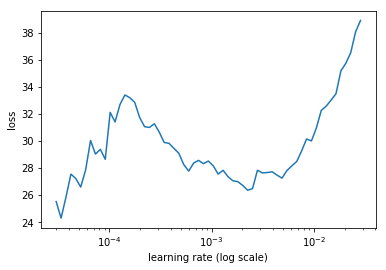

In [160]:
learner.sched.plot()

In [397]:
f2(val_probabilities, data.val_y)

0.732725493687921

In [398]:
metrics=[f2]

### Model creation
Create our model. 

In [399]:
learn = ConvLearner.pretrained(arch, data, precompute=True, metrics=metrics)

100%|██████████| 957/957 [02:03<00:00,  7.77it/s]


### Loss function
I think it's very important to reflect on the importance of the loss function. It is the driver of the evolution of our network, it's the very thing it's trying to optimize.<br>
Now that we are facing a multi-label classification problem, our loss function can adapt many more shapes and sizes.<br>
I could for instance:
<ul>
    <li> Do the mean of the binary cross-entropy for each category for each sample (our case)
    <li> I could count as positive only the samples where I predicted all the categories right.
    <li> My loss function could account for skewed classes and penalize more not recalling a rare category.
</ul>
The possibilities are almost endless, and the premise is very simple. It takes the predictions and the expected values and returns a real number.<br>
There are frameworks that can direcly approximate the gradient of a loss function so it's not as hard to come up with one.<br>
Anyways, loss fucntion engineering is out of the scope of this problem, but it seems to me like one of the most important areas of deep learning and I look forward to it.

We are going to implement the binary cross-entropy to truly understand how it works:<br>
<ul>
<li>We first  compute the cross entropy of the predicted probability and the real category element wise.<br>
<li>We then get the dimensions (number of categories and samples).<br>
<li>Finally, we flatten the matrix and we sum all the elements dividing by the total number of ocurrences.<br>
<li>Return the cost.

In [400]:
def binary_cross_entropy(probs, real_values):
    cost_matrix =  -(real_values * (np.log(probs)) + (1 - real_values) * (np.log(1-probs)))
    n_samples, n_categories = cost_matrix.shape
    cost = (1/(n_samples * n_categories)) * sum(cost_matrix.flatten())
    return cost

This function can't be used directly as a metric because the returned variable is not a torch.FloatTensor.<br>
Anyways, we can check it computes the right value by calling the function with the predicted probabilities for the validation set (we do it later).<br>

### Learning rate
Compute the learning rate related info

In [401]:
learn.lr_find()

epoch      trn_loss   val_loss   f2                           
    0      0.22184    0.28262    0.722532  



Our learning instance has a scheduler that exponentially increases the learning rate with each batch.<br>
Let's plot how this scheduler increases the learning rate with each iteration.

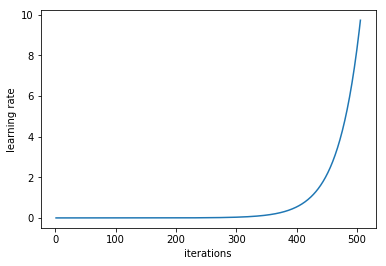

In [402]:
learn.sched.plot_lr()

Check how the loss decreases faster for a bigger learning rate until it becomes unstable.

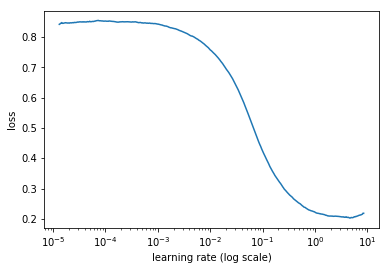

In [403]:
learn.sched.plot()

A learning rate of 0.2 seems like a reasonable choice.

In [406]:
lr = 0.2

### Stochastic gradient descent with restarts
We can relate the "size" of the local minimum to the generalitzation it can achieve.<br>
I like to think that noise has this cahotic highly variant nature whereas the perception we are looking for has a much more stable and invariant nature.<br>
It makes sense then that a huge stable local minimum predicts more on the perception than the noise.<br>
Using this theory we will restart the learning sheduler to unconverge from "small" local minimums in the hope to find a better "big" more generalitzating minimum.

### Cycle length
This parameter defines how many cycles or epochs we run before resetting the learning rate scheduler.

### Training
Train the model with the chosen learning rate for 2 epochs or cycles.<br>
The loss function used is the cross-entropy function.

In [405]:
start = time.time()
learn.fit(lrs=lr, n_cycle=3, cycle_len=1)
end = time.time()
print(f"Total seconds elapsed: {end-start}")

epoch      trn_loss   val_loss   f2                           
    0      0.145494   0.131852   0.654138  
    1      0.137569   0.125988   0.656596                     
    2      0.13495    0.124265   0.675905                     

Total seconds elapsed: 17.16628360748291


### Fine tunning

To fine tune our model we will unfreeze some previous layers.

In [329]:
learn.unfreeze()

Neural nets use a chain of abstractions to build a perception. The early layers work on general abstract patter recognition like edges or textures.<br>
To solve a particular problem, we will train the last layers to adapt to that particular problem. However, early layers don't have to be tuned that much thanks to their general nature.<br>
For that reason, we define an array of learning rates from the earlier layers to the latest.<br>
We divide the neural net in three parts, starting from the end, each earlier layer has a e-1 learning rate in respect to the next one.

In [330]:
lr=np.array([1e-4,1e-3,1e-2])

As we are approaching a more general minimum with SGDR (Stochastic Gradient Descent with Restarts) we would like to take longer to restart so our algorithm can converge.<br>
Cycle_mult does that, everytime a cycle ends the next cycle will be of length cycle_mult * previous_cycle.<br>
In this case: [1,2,4] for a total of 7 cycles.

In [331]:
start = time.time()
learn.fit(lr, n_cycle=3, cycle_len=1, cycle_mult=2)
end = time.time()
print(f"Total seconds elapsed: {end-start}")

epoch      trn_loss   val_loss   accuracy                    
    0      0.769088   0.565555   0.828278  
    1      0.702861   0.540051   0.835616                    
    2      0.651116   0.529273   0.837084                    
    3      0.66464    0.517826   0.84002                     
    4      0.621571   0.511984   0.838552                    
    5      0.556689   0.496397   0.840998                    
    6      0.546734   0.495952   0.841487                    

Total seconds elapsed: 498.1215765476227


### Save the trained model

Finally, so we don't have to compute the model again, we can save the weights and the configuration in a file.<br>

In [411]:
model_name = "224_all"
learn.save(model_name)

The model is now saved in the "models" directory as 224_all.h5

### Load the trained model
We can use an already trained model in the models directory.

In [412]:
learn.load('224_all')

<br>
<br>
<a id="model_validation"> </a>
# 5. Model validation

<br>
## 5.1 Making the predictions

### Understanding the output

We should be worried about the chosen activation function for our last layer, as it's nature is going to greatly define the neural network.<br>
Let's check out what the last layer activation function is.

In [407]:
learn[-1]

Sigmoid()

The last layer outputs the sigmoid of the activations of the previous layer (read that again).

In this case, the sigmoid function presents the following properties:
   - All the outputs are contained between 0 and 1.
   - It can choose multiple categories at the same time.

Now let's think about our current dataset. This neural network has to predict if the image belongs to multiple categories.
So we could see our prediction as a multi label problem where it makes sense to predict more than one category.
This goes well with the properties of the sigmoid function, so it seems like a reasonable choice to use as the last layer.


### Making the validation set predictions

Important reminder. All the prediction related data of our neural network is contained in the data object we created in the model training.<br>
<ul>
    <li>To obtain the ordered classes we use the <b>data.classes</b> attribute.
    <li>To obtain the ordered validation images we use the <b>data.val_ds.fnames</b> attribute.
    <li>To obtain the original labels of the validation set we use <b>data.val_y</b> attribute.
</ul>

We set the is_test flag to False to tell the model to predict on the validation set.<br>
We compute the exponential of the output to get the probabilities in the 0 to 1 range.

### Test time augmentation
There's another neat trick we can apply to obtain better results.
TTA uses the average prediction for n augmentations of the original test image. If the augmentations are correctly tuned, TTA offers a more robust prediction.<br>
TODO TTA getting the most certain prediction?

In [408]:
TTA_enabled_validation = False

In [409]:
if TTA_enabled_validation:
    val_aug_predictions, dummy = learn.TTA(n_aug=4, is_test=False)
    val_probabilities = np.mean(val_aug_predictions,0)
else:
    val_probabilities = learn.predict(is_test=False)
val_predictions = np.where(val_probabilities > 0.9, 1, 0) # The index of the max value directly maps the category (0 -> cat, 1 -> dog)

Using TTA we can get a 12% error reduction at this point, that's a huge improvement for such little effort.

### Check binary cross entropy
Check that the binary cross-entropy function we wrote before correctly computes the cost.<br>

In [410]:
binary_cross_entropy(val_probabilities, data.val_y)

0.12426533228207949

### Measure accuracy

Multi label classification is more open to interpretation when it comes to metrics.<br>
In this case to measure accuracy we will compare all the predicted categories with the real value for all the predictions and count how many it got right.

In [411]:
correct_guesses  = (val_predictions == data.val_y)
correct_guesses_flattened = correct_guesses.flatten()
accuracy = np.sum(correct_guesses_flattened)/len(correct_guesses_flattened)
print(accuracy)

0.9298550303382626


<br>
## 5.2 Visualising the predictions

<br>
### Classification report

Sklearn provides a very useful set of metrics for single label, multi class classification.<br>
It gives us 3 metrics (tp = true positive / fp = false positive / fn = false negative):
<ul>
    <li> Precision: Of all the predicted positives for this class, how many where actually correct? 
           $$\frac{tp} {tp + fp}$$ </li><br>
    <li> Recall: What percentage of all the positives for this class where detected?
           $$\frac{tp} {tp + fn}$$ </li><br>
    <li> F1 Score:    $$2 · \frac{precision · recall} {precision + recall}$$ </li><br>
    <li> Support: Total number of correctly guessed images </li>
</ul>


In [412]:
print(classification_report(data.val_y, val_predictions, target_names=data.classes))

C:\Users\David\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   precision    recall  f1-score   support

      agriculture       0.96      0.31      0.46      2497
   artisinal_mine       1.00      0.10      0.18        70
      bare_ground       0.00      0.00      0.00       162
         blooming       0.00      0.00      0.00        61
        blow_down       0.00      0.00      0.00        16
            clear       0.98      0.80      0.88      5701
           cloudy       0.97      0.28      0.43       401
conventional_mine       1.00      0.05      0.10        19
      cultivation       0.00      0.00      0.00       931
       habitation       0.90      0.02      0.05       736
             haze       1.00      0.01      0.01       537
    partly_cloudy       0.97      0.47      0.63      1456
          primary       0.99      0.95      0.97      7493
             road       0.96      0.23      0.37      1552
selective_logging       0.00      0.00      0.00        69
       slash_burn       0.00      0.00      0.00       

F1 Score is a very useful metric for skewed classes.<br> In this case, classes are very unbalanced and some of them are very hard to detect with precision and recall. The warning it's due to the indetermination caused by 0 recall and 0 precision (0/0).<br>
<br>
Some categories are completely unnoticed, their impact on the cost function is so low that the optimal neural net doesn't even consider this rare cases.<br><br>
For the sake of the competition, if we are already optimizing whatever function they are evaluating us on, it's not our problem that this happens.<br>
However, if it was important for us to take into account this kind of categories, then we should build a cost function that would take this into account.<br><br>
As an idea, we could compute the cost for each category and then multiply it by the inverse of the probability for that category. This would increase greatly the cost for rare categories and increase slightly the cost for common categories.<br>
This could lead to some serious overfitting, so if we don't have many samples for rare categories we should perform some data augmentation on them.<br><br>
TODO: evaluate this ideas sometime

### Worst categories
Below we can see the categories with the lowest F1 Scores.<br>
We should prioritize this categories.

In [413]:
precision, recall, f1_score, support = precision_recall_fscore_support(data.val_y, val_predictions)
worst_categories_indexes = np.argpartition(f1_score, 10)[0:10]
print( "Class\t\t\t\t\t\tF1-Score")
for index in worst_categories_indexes:
    current_class = data.classes[index]
    spaces = " " * (48 - len(current_class))
    print(f"{data.classes[index]}{spaces}{round(f1_score[index],3)}")

C:\Users\David\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Class						F1-Score
haze                                            0.011
cultivation                                     0.0
bare_ground                                     0.0
blooming                                        0.0
blow_down                                       0.0
slash_burn                                      0.0
selective_logging                               0.0
conventional_mine                               0.1
artisinal_mine                                  0.182
habitation                                      0.048


### Predictions format

The prediction is represented as an array of predictions for each of the categories  sorted in the appearing order in data.test_ds.fnames.<br>
In this case, the model is a single label classifier for 120 categories, so the prediction for an image is the index of the category.<br>


In [414]:
print(f"Example of a prediction for an image: {val_predictions[43]}")
print(f"The size of the probabilities array is: {np.size(val_probabilities[43])}")

Example of a prediction for an image: [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
The size of the probabilities array is: 17


### Analyzing the validation set predictions

First we will create some functions to plot the results

Random indexes from mask gets n random indexes of the validation predictions if that index is True in the mask array.<br>
np.where(mask)[0] returns the indexes where the mask element is True: [True, False, True] --> [0,2]<br>
It doesn't replace the chosen images to avoid duplicates.

In [415]:
def random_indexes_from_mask(mask_array, n): 
    return np.random.choice(np.where(mask_array)[0], n, replace=False)

Random indexes by prediction returns n random indexes of the predictions that are either correct or incorrect depending on is_correct.<br>
It supplies the mask array to random indexes from mask which then selects the images indexes.

In [416]:
def random_indexes_by_prediction(is_correct, n):
    mask_array = (val_predictions == data.val_y) == is_correct
    return random_indexes_from_mask(mask_array, n)

Plot image with title selects the images and the probabilites of the provided category and plots them.<br>

In [417]:
def plot_image_with_title(idxs, title, category_index=False):
    images = [plt.imread(f"{INPUT_PATH}{s}{data.val_ds.fnames[i]}") for i in idxs] # Select the images filenames and create a list of the loaded images
    if not category_index:
        images_probabilities = [val_probabilities[i][val_predictions[i]] for i in idxs] # Select the y category probability for each image
    else:
        images_probabilities = [val_probabilities[i][category_index] for i in idxs] # Select the y category probability for each image
    print(title)
    return plots(images, rows=1, titles=None)

Plots configures the plotting options.

In [418]:
def plots(imgs, figsize=(12,6), rows=1, titles=None):
    figure = plt.figure(figsize=figsize)
    columns = len(imgs)//rows
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, columns, i+1)
        subplot.axis("Off")
        if titles is not None: subplot.set_title(titles[i], fontsize=16)
        plt.imshow(imgs[i])

### Random correctly classified images

Let's see some correctly classified images

Correctly classified


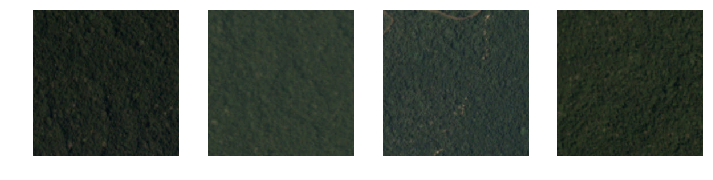

In [419]:
plot_image_with_title(random_indexes_by_prediction(True, n=4), "Correctly classified")

Let's see some incorrectly classified images

### Random incorrectly classified images

Incorrectly classified


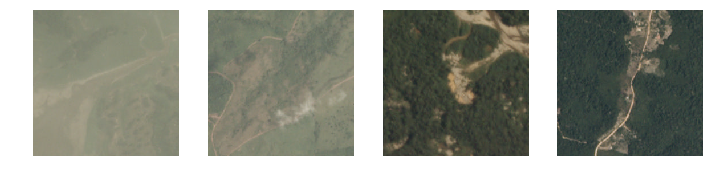

In [420]:
plot_image_with_title(random_indexes_by_prediction(False, n=4), "Incorrectly classified")

### Most correct, incorrect and uncertain

Most by mask gets a mask of the correctly or incorrectly classified class and sorts the indexes to extract the most correct, incorrect or uncertain images.<br>
np.argsort() sorts in increasing order.<br>
Because we are using the dogs probabilities to compute

In [421]:
def most_by_mask(mask, y, mult):
    indexes = np.where(mask)[0]
    sorted_indexes = indexes[np.argsort(mult * val_probabilities[:,y][indexes])[-4:]]
    return sorted_indexes

Because np.argsort() sorts in increasing order, and we get the last n sorted indexes, when finding the most inccorrect images for a category we must multiply the probabilities by -1 so the worst guesses have the highest numbers. For that reason we generate the mult variable.<br>
Ex: [0.4, 0.2, 0.01, 0.3] --> (-1) --> [-0.4, -0.2, -0.3, -0.01] <br><br>
The mask array generation can be thought as follows:
 - The current example is a valid (True) if the prediction is correct and we are looking for correct predictions and the category is the one selected.
 - The current example is a valid (True) if the prediction is incorrect and we are looking for incorrect predictions and the category is the one selected.

### Select the category
Select the category from one of the following breeds.

In [422]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [423]:
category = input("What category would you like to visualize: ")
while category not in data.classes:
    print("Category not valid, please enter a valid category")
    category = input("What category would you like to visualize: ")
category_index = data.classes.index(category)

What category would you like to visualize: haze


### Most correct

In [424]:
def most_by_correct(y, is_correct, is_expected_category):
    mult = 1 if is_correct else -1
    mask_array = [((val_predictions[i][y] == data.val_y[i][y]) == is_correct) & ((data.val_y[i][y] == is_expected_category)) for i in range(len(val_predictions))]
    indexes = np.where(mask_array)[0]
    sorted_indexes = most_by_mask(mask_array, y, mult)
    print(sorted_indexes)
    return sorted_indexes

[4694 5628 5009]
Most correct haze


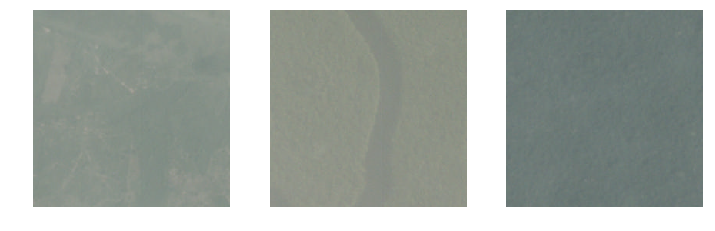

In [425]:
plot_image_with_title(most_by_correct(category_index, True, True), f"Most correct {category}", category_index)

In [426]:
def categories_and_probabilities_by_index(index):
    sample_categories = data.val_y[index]
    for i, is_category in enumerate(sample_categories):
        if is_category:
            print(data.classes[i], val_probabilities[index][i])
        


In [427]:
categories_and_probabilities_by_index(1307)

agriculture 0.8289081
partly_cloudy 0.7933252
primary 0.4951746


In [428]:
len(data.val_y[5102])

17

### False negatives

[4927 2914 7163 4643]
Most incorrect false negatives haze


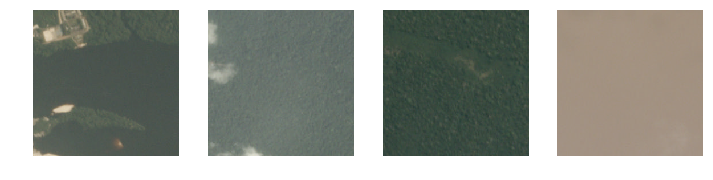

In [429]:
plot_image_with_title(most_by_correct(category_index, False, True), f"Most incorrect false negatives {category}", category_index)

### False positives

[4558  519  651 2177]
Most incorrect false positives haze


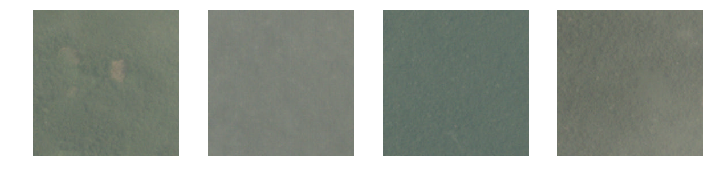

In [430]:
plot_image_with_title(most_by_correct(category_index, True, False), f"Most incorrect false positives {category}", category_index)

### Uncertain

To check the most uncertain:
 - Select thr probabilities of one category (in this case dogs)
 - Substract 0.5
 - Compute the absolute value
 - Get the n smallest elements (closer to 0.5).

Most uncertain predictions for haze


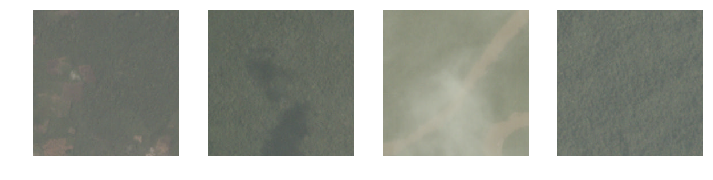

In [431]:
most_uncertain_indexes = np.argsort(np.abs(val_probabilities[:,category_index] -0.5))[:4]
plot_image_with_title(most_uncertain_indexes, f"Most uncertain predictions for {category}")

<br>
<br>
<a id="model_predictions"> </a>
# 6. Model predictions

<br>
## 6.1 Making the test set predictions

Set the is_test flag to True to tell the model to predict on the test set.<br>
Compute the exponential of the output to get the probabilities in the 0 to 1 range.
We can enable TTA on the test predictions.

In [432]:
TTA_enabled_test = False

In [433]:
if TTA_enabled_test:
    test_aug_predictions, dummy = learn.TTA(n_aug=4, is_test=True)
    test_probabilities = np.mean(test_aug_predictions)
else:
    test_probabilities = learn.predict(is_test=True)
test_predictions = np.where(test_probabilities > 0.9, 1, 0)

The probabilities for m test cases will result in a list of the probabilities of each image for each category.<br>
It can be thought as an m*c matrix

In [434]:
np.shape(test_probabilities)

(61191, 17)

Check the output dimension is correct.

In [435]:
if np.shape(test_probabilities)[1] != n_categories:
    print("FATAL ERROR, output dimension doesn't match the number of categories")
else:
    print("Output dimension correct")

Output dimension correct


<br>
## 6.2 Create the test  predictions dataframe

###  Linking the labels

Apply to all the predictions.

In [436]:
predicted_labels = []
for prediction in test_predictions:
    categories_predicted = []
    for category_index, category_predicted in enumerate(prediction):
        if category_predicted:
            categories_predicted.append(data.classes[category_index])
    predicted_labels.append(" ".join(categories_predicted))
print(f"An example of a prediction: {predicted_labels[42]}")

An example of a prediction: clear primary


### Test probabilities dataframe

The probabilities dataframe will have the following structure:
 - A column for each category with the probabilities for each image.

In [437]:
images_names_column = [image_file_name[9:-4] for image_file_name in data.test_ds.fnames]

In [438]:
images_names_column[1]

'file_1'

In [439]:
test_probabilities_df = pd.DataFrame(test_probabilities, columns=data.classes)
test_probabilities_df.info()
test_probabilities_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61191 entries, 0 to 61190
Data columns (total 17 columns):
agriculture          61191 non-null float32
artisinal_mine       61191 non-null float32
bare_ground          61191 non-null float32
blooming             61191 non-null float32
blow_down            61191 non-null float32
clear                61191 non-null float32
cloudy               61191 non-null float32
conventional_mine    61191 non-null float32
cultivation          61191 non-null float32
habitation           61191 non-null float32
haze                 61191 non-null float32
partly_cloudy        61191 non-null float32
primary              61191 non-null float32
road                 61191 non-null float32
selective_logging    61191 non-null float32
slash_burn           61191 non-null float32
water                61191 non-null float32
dtypes: float32(17)
memory usage: 4.0 MB


,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.008462,0.000139,0.000520,0.066409,0.001485,0.996633,0.000064,0.000144,0.008791,0.002502,0.000487,0.003865,0.999866,0.007273,0.012964,0.000404,0.006730
1,0.811923,0.005583,0.123924,0.001213,0.002280,0.863313,0.003726,0.002029,0.142970,0.150910,0.002842,0.179346,0.959321,0.514152,0.002168,0.005697,0.184169
2,0.191155,0.002536,0.016598,0.001441,0.000847,0.412472,0.012373,0.000868,0.026259,0.032929,0.489048,0.026539,0.953281,0.540154,0.002697,0.001612,0.824123
3,0.130748,0.000757,0.006408,0.001556,0.000840,0.970495,0.001241,0.000298,0.098223,0.035319,0.039250,0.007293,0.997302,0.183825,0.005742,0.002751,0.813616
4,0.016772,0.000162,0.000421,0.012100,0.002219,0.983481,0.000255,0.000113,0.011910,0.002565,0.000238,0.035667,0.999507,0.006676,0.006366,0.000566,0.007197


### Test predictions dataframe

 The predictions dataframe will have the following structure:
 - A column with the names of the images with a "filename" header
 - A column with the predicted category with the "category" header

In [440]:
test_predictions_df  = pd.DataFrame(data = {"filename":images_names_column, "category": predicted_labels}, 
                                       columns=["filename", "category"])
test_predictions_df.head()

,filename,category
0,file_0,clear primary
1,file_1,primary
2,file_10,primary
3,file_100,clear primary
4,file_1000,clear primary


<br>
## 6.3 Submission

In this kaggle competition, we upload the predictions as a csv file. F2 score with a Beta of 2 is used to evaluate our predictions. For that reason, we will directly provide the predicted categories. The format is established as follows:<br>
<li> Extract the image filenames in a "image_name" column
<li> Extract the predictions as a space separated string in a "tags" column.


In [441]:
submission_df = test_predictions_df
submission_df = submission_df.rename(columns={"filename": "image_name", "category": "tags"})
submission_df.info()
submission_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61191 entries, 0 to 61190
Data columns (total 2 columns):
image_name    61191 non-null object
tags          61191 non-null object
dtypes: object(2)
memory usage: 956.2+ KB


,image_name,tags
0,file_0,clear primary
1,file_1,primary
2,file_10,primary
3,file_100,clear primary
4,file_1000,clear primary


Define the submission name and path.

In [443]:
submission_filename = "submission2"
submission_path = f"{INPUT_PATH}{s}submission{s}{submission_filename}.csv"

Create the submission file without the index column.

In [444]:
submission_df.to_csv(submission_path,index=False)

Generate a link to a direct download of the submission file.

In [354]:
FileLink(submission_path)

C:\Users\David\Desktop\Kaggle\planet_amazon\input\submission\submission.csv

## Review: easy steps to train a world-class image classifier

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting